# Anomaly Detection with Temperature, Humidity, and Gas Sensor Data

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
# JSON file
json_file = "dataset/temp-humidity-gas-sensor-data-default-rtdb-export.json"

# Convert JSON to pandas dataframe
json_data = pd.read_json(json_file, orient='split')
dataset = json_data.transpose()
print(dataset)

dataset.to_csv("dataset/dataset.csv")

print(dataset.mean().astype(np.float16))
print(dataset.std().astype(np.float16))

                       CO_PPM  humidity  temperature     timestamp
-MvcSM8n2zjpCYWQLTvU  3.84332      39.0         21.8  1.644578e+09
-MvcSOF8lv_CtymC_qTC  3.97888      38.0         21.8  1.644578e+09
-MvcSQgOdqNMFrPJT2OJ  3.97888      38.0         21.8  1.644578e+09
-MvcST7f63qislrlRoK9  3.95595      38.0         21.8  1.644578e+09
-MvcSV_-QmoXbj5VEpyY  4.00194      38.0         21.9  1.644578e+09
...                       ...       ...          ...           ...
-MvozH3ipUWFw-WonOw0  2.83316      47.0         21.7  1.644788e+09
-MvozJVu3BddkEnYpSIX  2.96710      47.0         21.7  1.644788e+09
-MvozLxDSTrQoGCKzxC4  2.97854      47.0         21.7  1.644788e+09
-MvozOcTjKdbmL-Yp5fM  2.98428      47.0         21.7  1.644788e+09
-MvozQq5gOK9uvNpjajW  2.99580      47.0         21.7  1.644788e+09

[1082 rows x 4 columns]
CO_PPM          4.597656
humidity       45.000000
temperature    22.218750
timestamp            inf
dtype: float16
CO_PPM         1.625000
humidity       6.957031
temperat

In [4]:
# Just read the CSV file if ready
dataset = pd.read_csv('dataset/dataset.csv')

# Remove first column (index column)
dataset = dataset.iloc[: , 1:]

Text(0, 0.5, 'CO Concentration (PPM)')

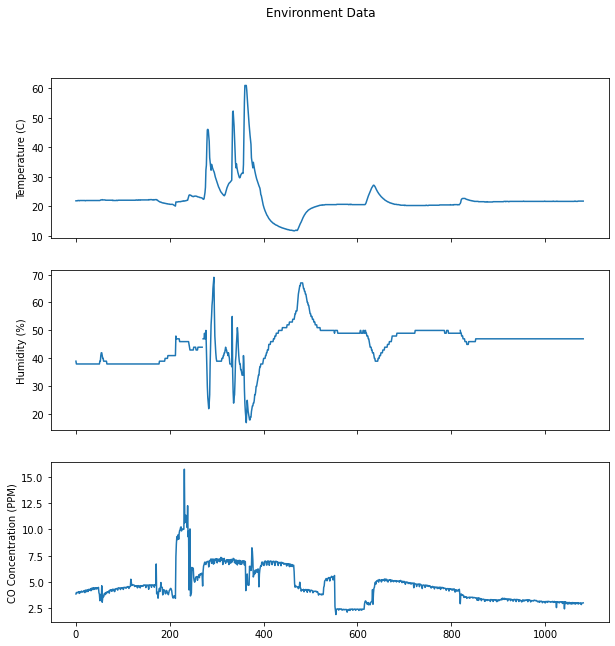

In [5]:
## Visualize the data

# Time-series visualization
fig, (temp_plot, hum_plot, gas_plot) = plt.subplots(3, sharex=True, figsize=(10,10))
fig.suptitle('Environment Data')

temp_data = dataset["temperature"]
humidity_data = dataset["humidity"]
co_data = dataset["CO_PPM"]

temp_plot.plot(temp_data)
temp_plot.set_ylabel("Temperature (C)")
hum_plot.plot(humidity_data)
hum_plot.set_ylabel("Humidity (%)")
gas_plot.plot(co_data)
gas_plot.set_ylabel("CO Concentration (PPM)")

Text(0.5, 0, 'CO Concentration (PPM)')

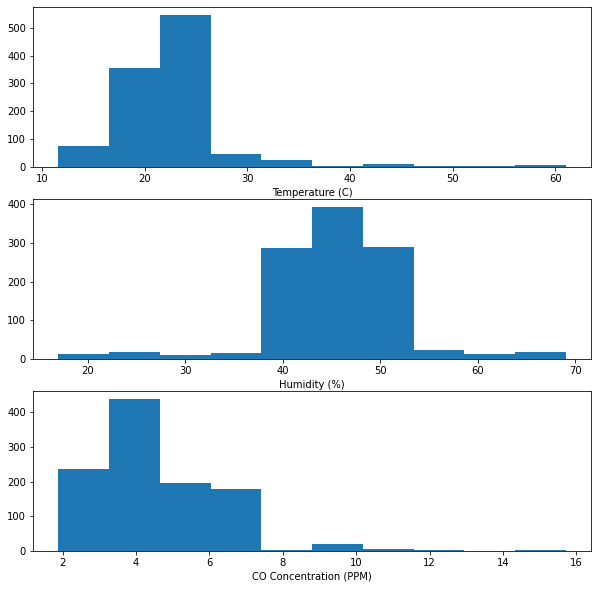

In [6]:
# Plot histogram
hist_fig, (temp_hist, hum_hist, gas_hist) = plt.subplots(3, figsize=(10,10))

temp_hist.hist(temp_data)
temp_hist.set_xlabel("Temperature (C)")

hum_hist.hist(humidity_data)
hum_hist.set_xlabel("Humidity (%)")

gas_hist.hist(co_data)
gas_hist.set_xlabel("CO Concentration (PPM)")

Text(0, 0.5, 'Humidity (%)')

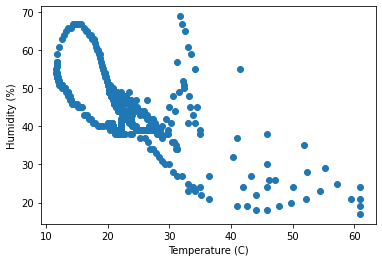

In [7]:
# Multivariate visualization
plt.scatter(temp_data, humidity_data)
plt.xlabel("Temperature (C)")
plt.ylabel("Humidity (%)")

Text(0.5, 0, 'CO Concentration (PPM)')

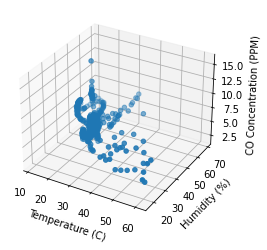

In [8]:
# Data for three-dimensional scattered points
multivar = plt.axes(projection='3d')
zdata = co_data
xdata = temp_data
ydata = humidity_data
multivar.scatter3D(xdata, ydata, zdata)

multivar.set_xlabel('Temperature (C)')
multivar.set_ylabel('Humidity (%)')
multivar.set_zlabel('CO Concentration (PPM)')

In [9]:
from sklearn.model_selection import train_test_split

# Drop timestamp column
dataset = dataset.drop(['timestamp'], axis =1)

# Drop incomplete rows
dataset = dataset.dropna(axis=0)

# Split the data
RANDOM_SEED = 101
x_train, x_test = train_test_split(dataset, test_size=0.2, random_state = RANDOM_SEED)

x_train = x_train.values
x_test  = x_test.values

print('Training data size   :', x_train.shape)
print('Validation data size :', x_test.shape)

dataset.head()

Training data size   : (864, 3)
Validation data size : (216, 3)


,CO_PPM,humidity,temperature
0,3.84332,39.0,21.8
1,3.97888,38.0,21.8
2,3.97888,38.0,21.8
3,3.95595,38.0,21.8
4,4.00194,38.0,21.9


In [10]:
# Normalize the data to give equal importance to features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

print(x_train)
print(x_train_scaled)
# print(x_test_scaled)

[[ 5.02497 49.      20.3    ]
 [ 4.28116 38.      21.9    ]
 [ 6.97323 45.      15.2    ]
 ...
 [ 4.13518 38.      22.     ]
 [ 2.3992  49.      20.5    ]
 [ 3.34992 47.      21.5    ]]
[[0.30325698 0.61538462 0.17611336]
 [0.23140044 0.40384615 0.20850202]
 [0.49147065 0.53846154 0.07287449]
 ...
 [0.21729789 0.40384615 0.21052632]
 [0.04959174 0.61538462 0.18016194]
 [0.14143703 0.57692308 0.20040486]]


In [11]:
# Build the model
from keras.layers import Input, Dense
from keras import regularizers
from tensorflow.keras import Model

input_dim = x_train.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(encoding_dim - 1), activation="tanh")(encoder)
encoder = Dense(int(1), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim - 1), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 3)                 12    

In [12]:
import datetime
# Train the model

nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(x_train_scaled, x_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history.history)

print(df_history)

Time to run the model: 5.349241 Sec.
        loss  val_loss
0   0.161289  0.135847
1   0.119626  0.112378
2   0.101576  0.097171
3   0.087086  0.083361
4   0.074233  0.071461
..       ...       ...
95  0.008544  0.010539
96  0.008542  0.010529
97  0.008535  0.010538
98  0.008533  0.010527
99  0.008527  0.010545

[100 rows x 2 columns]


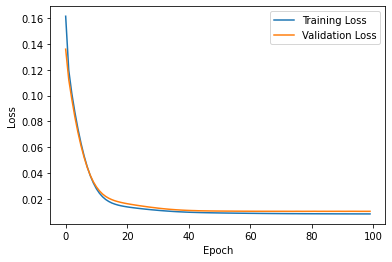

In [13]:
epoch_list = df_history.index.tolist()
loss_list = df_history['loss'].tolist()
val_loss_list = df_history['val_loss'].tolist()

plt.plot(epoch_list, loss_list, label='Training Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

### Model Evaluation

,reconstruction_error
count,216.000000
mean,0.009485
std,0.022045
min,0.000061
25%,0.001517
50%,0.002821
75%,0.006986
max,0.259612


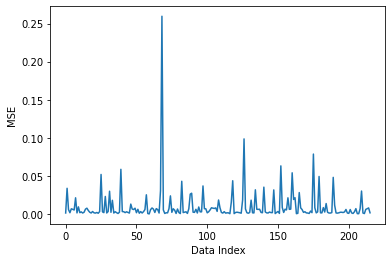

In [14]:
predictions = autoencoder.predict(x_test_scaled)
# print(predictions)

mse = np.mean(np.power(x_test_scaled - predictions, 2), axis=1)
# print(mse)
plt.plot(mse)
plt.xlabel("Data Index")
plt.ylabel("MSE")

# df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error = pd.DataFrame({'reconstruction_error': mse})
df_error.describe()

In [15]:
outliers = df_error.index[df_error.reconstruction_error > 0.1].tolist()

for outlier in outliers:
    print(outlier, x_test[outlier])

68 [15.71017 46.      21.7    ]


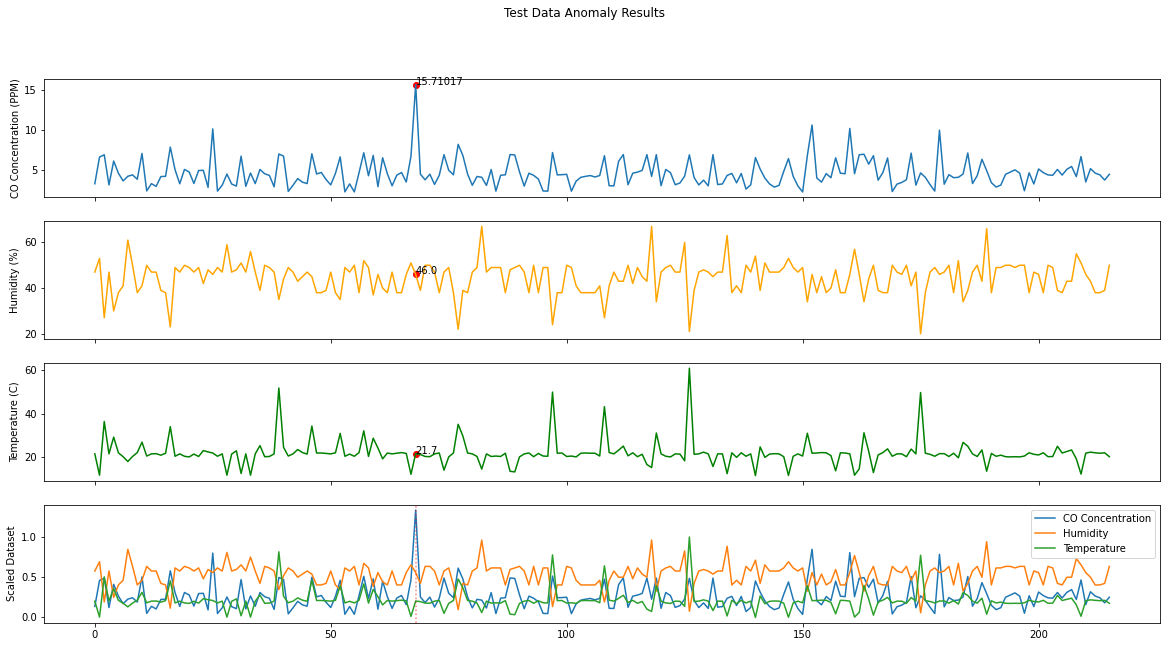

In [16]:
# Plot outliers in the test data
fig2, (gas_anomaly, hum_anomaly, temp_anomaly, scaled_anomaly) = plt.subplots(4, sharex=True, figsize=(20,10))
fig2.suptitle('Test Data Anomaly Results')

# print(pd.DataFrame(x_test))
x_test_pd = pd.DataFrame(x_test)

gas_anomaly.plot(x_test_pd[0])
gas_anomaly.set_ylabel("CO Concentration (PPM)")
hum_anomaly.plot(x_test_pd[1], c='orange')
hum_anomaly.set_ylabel("Humidity (%)")
temp_anomaly.plot(x_test_pd[2], c='g')
temp_anomaly.set_ylabel("Temperature (C)")

scaled_anomaly.plot(x_test_scaled)
# scaled_anomaly.plot(df_error, c='grey', label='MSE')
scaled_anomaly.set_ylabel("Scaled Dataset")
scaled_anomaly.legend(['CO Concentration', 'Humidity', 'Temperature'])

for outlier in outliers:
    temp_anomaly.scatter(outlier, x_test[outlier][2], c='r')
    temp_anomaly.annotate(x_test[outlier][2], (outlier, x_test[outlier][2]))
    hum_anomaly.scatter(outlier, x_test[outlier][1], c='r')
    hum_anomaly.annotate(x_test[outlier][1], (outlier, x_test[outlier][1]))
    gas_anomaly.scatter(outlier, x_test[outlier][0], c='r')
    gas_anomaly.annotate(x_test[outlier][0], (outlier, x_test[outlier][0]))
    scaled_anomaly.axvline(outlier, c='red', alpha=0.5, linestyle='dotted')

### Get weights and biases from the model

In [17]:
# Note that we transpose W2. This makes the inner loop for the
# matrix multiplication a little simpler.

names = []
arrays = []

for i in range(1, len(autoencoder.layers)):
    weight_data_name = "W" + str(i) + "_data"
    bias_data_name = "b" + str(i) + "_data"
    names.append(weight_data_name)
    names.append(bias_data_name)

    weight_name, bias_name = autoencoder.layers[i].get_weights()
    arrays.append(weight_name)
    arrays.append(bias_name)
    print(bias_name.shape, weight_name.shape)

(3,) (3, 3)
(2,) (3, 2)
(1,) (2, 1)
(2,) (1, 2)
(3,) (2, 3)
(3,) (3, 3)


In [18]:
# Copy this into model_data.cpp:

for name, array in zip(names, arrays):
    print("const float %s[] PROGMEM = {" % name)
    # print("   ", ", ".join([str(x) + "f" for x in array.flatten()]))
    print("   ", ", ".join([str(x) + "f" for x in array.flatten()]))
    print("};\n")

const float W1_data[] PROGMEM = {
    1.147827f, 0.4261691f, -0.34158963f, 0.25895673f, 1.0249484f, -0.12842806f, 0.38315338f, -0.8323818f, -0.21700472f
};

const float b1_data[] PROGMEM = {
    -0.16646554f, 0.051293723f, 0.0064696474f
};

const float W2_data[] PROGMEM = {
    1.0557481f, -0.3327157f, 0.323279f, 0.74503917f, -0.059983943f, 0.28870338f
};

const float b2_data[] PROGMEM = {
    -0.0669622f, -0.029682815f
};

const float W3_data[] PROGMEM = {
    0.45077962f, -1.0204022f
};

const float b3_data[] PROGMEM = {
    0.052652925f
};

const float W4_data[] PROGMEM = {
    0.92189723f, 1.1308191f
};

const float b4_data[] PROGMEM = {
    -0.090387665f, 0.22086267f
};

const float W5_data[] PROGMEM = {
    -1.1304666f, 0.93807936f, 0.8790146f, -0.15796769f, 0.25851104f, -0.17650656f
};

const float b5_data[] PROGMEM = {
    0.06269418f, 0.13795264f, -0.21045631f
};

const float W6_data[] PROGMEM = {
    0.041467156f, 0.31839973f, 0.27148622f, 1.0523025f, 0.3081028f, 0.7726632f, 

### Test model outputs

In [22]:
dummy_input = [[-0.43, -0.86, 0.01]]

predictions = autoencoder.predict(dummy_input)
print(predictions)

mse = np.mean(np.power(dummy_input - predictions, 2), axis=1)
print(mse)

[[0.18644956 0.590812   0.16393891]]
[0.83618759]
